In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
import json
from tqdm.autonotebook import tqdm
from collections import Counter
import time

from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen import predict

import torch

C:\Users\vijmr\AppData\Local\Temp/ipykernel_17796/373539399.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
C:\Users\vijmr\anaconda3\envs\cv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [6]:
subjects = ['Alice', 'Alice', 'Alice', 'Alice', 'Alice', 'Alice', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Bob', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'Charlie', 'David', 'David', 'David', 'David', 'David', 'David', 'Eve', 'Eve', 'Eve', 'Eve', 'Eve', 'Eve']
predicates = ['friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation', 'friend_with', 'friend_with', 'has_hobby', 'has_hobby', 'has_occupation', 'has_occupation']
objects = ['Bob', 'Charlie', 'Reading', 'Swimming', 'Engineer', 'Scientist', 'Alice', 'David', 'Football', 'Cycling', 'Doctor', 'Chef', 'Alice', 'Eve', 'Gaming', 'Photography', 'Teacher', 'Lawyer', 'Bob', 'Frank', 'Swimming', 'Hiking', 'Lawyer', 'Pilot', 'Charlie', 'Frank', 'Painting', 'Running', 'Chef', 'Nurse']


df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})

In [7]:
# triplets dataset
triplets_df = df

In [8]:
triplets_df

,subject,predicate,object
0,Alice,friend_with,Bob
1,Alice,friend_with,Charlie
2,Alice,has_hobby,Reading
3,Alice,has_hobby,Swimming
4,Alice,has_occupation,Engineer
5,Alice,has_occupation,Scientist
6,Bob,friend_with,Alice
7,Bob,friend_with,David
8,Bob,has_hobby,Football
9,Bob,has_hobby,Cycling


In [9]:
Counter(triplets_df["predicate"])

Counter({'friend_with': 10, 'has_hobby': 10, 'has_occupation': 10})

In [10]:
triplets_df.dtypes

subject      object
predicate    object
object       object
dtype: object

In [11]:
# PyKeen triplets + train-test split
tf = TriplesFactory.from_labeled_triples(triplets_df.values)
training, testing = tf.split([0.8,0.2], random_state = 0)

In [12]:
training

TriplesFactory(num_entities=23, num_relations=3, create_inverse_triples=False, num_triples=24)

In [13]:
testing

TriplesFactory(num_entities=23, num_relations=3, create_inverse_triples=False, num_triples=6)

In [14]:
# create a pykeen model + preprocessing pipeline
result = pipeline(
    model = 'TransE',
    loss = 'softplus',
    training = training, 
    testing = testing, 
    model_kwargs = dict(embedding_dim = 100, random_seed=0),
    optimizer = torch.optim.Adam,
    training_loop = 'sLCWA',
    negative_sampler = 'bernoulli',
    optimizer_kwargs = dict(lr = 0.001),
    training_kwargs = dict(num_epochs = 100, batch_size = 128, use_tqdm_batch = False)
)

No random seed is specified. Setting to 1246034541.
No cuda devices were available. The model runs on CPU


Training epochs on cpu:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on cpu:   0%|          | 0.00/6.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

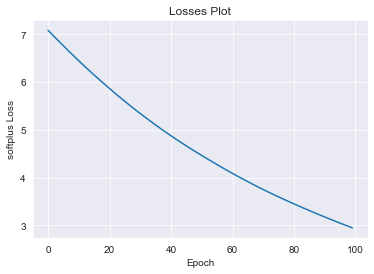

In [15]:
model = result.model
result.plot_losses()

In [16]:
# create a rank based evaluator object for test set performance metrics
evaluator = RankBasedEvaluator()
metrics = evaluator.evaluate(result.model, testing.mapped_triples,
                             additional_filter_triples = [training.mapped_triples])

Evaluating on cpu:   0%|          | 0.00/6.00 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds


In [22]:
## fake data so no good performance
print(f"Hits@1: {metrics.get_metric('tail.hits@1')}")
print(f"Hits@3: {metrics.get_metric('tail.hits@3')}")
print(f"Hits@5: {metrics.get_metric('tail.hits@5')}")
print(f"Hits@10: {metrics.get_metric('tail.hits@10')}")
print(f"Mean reciprocal rank: {metrics.get_metric('tail.mean_reciprocal_rank')}")

Hits@1: 0.0
Hits@3: 0.0
Hits@5: 0.0
Hits@10: 0.5
Mean reciprocal rank: 0.10406331221262614
